In [1]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

def sampleChania(Chania, n_points):
    np.random.seed(4)
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

Chania = np.genfromtxt('processedChania.csv', delimiter=',')

Chania = Chania[np.where(Chania[:,2]<99)]

In [77]:
# NOISE = [50]
# all_data = np.empty((10*len(NOISE),3))
# average_data = np.empty((6,3))

# for N in range(len(NOISE)):

#     for i in range(10):

#         strategy = "simple"

#         sess = tf.Session()
#         keras.backend.set_session(sess)

#         x, trueusers = sampleChania(Chania, 100)

#         if strategy == "simple":
#             yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(100,4))
#             y = tf.constant(yarray, tf.float32)

#         i1 = keras.layers.Dense(4, activation=tf.nn.relu)
#         i2 = keras.layers.Dense(4, activation=tf.nn.relu)
#         i3 = keras.layers.Dense(4, activation=tf.nn.relu)
#         i4 = keras.layers.Dense(1)

#         m1 = i4(i3(i2(i1(x[:,2:]))))
#         m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
#         m1_train = tf.train.GradientDescentOptimizer(0.2)
#         m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

#         o1 = keras.layers.Dense(4, activation=tf.nn.relu)
#         o2 = keras.layers.Dense(4, activation=tf.nn.relu)
#         o3 = keras.layers.Dense(4, activation=tf.nn.relu)
#         o4 = keras.layers.Dense(1)

#         m2 = o4(o3(o2(o1(y[:,2:]))))
#         m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
#         m2_train = tf.train.GradientDescentOptimizer(0.2)
#         m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

#         a1 = keras.layers.Dense(7, activation=tf.nn.relu)
#         a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

#         users = a2(a1(y))
#         a_train = tf.train.GradientDescentOptimizer(0.08)
#         a_vars = [a1.variables, a2.variables]

#         m1_loss = tf.placeholder(tf.float32)
#         m2_loss = tf.placeholder(tf.float32)
#         map_error = tf.placeholder(tf.float32)
#         adversary_loss = tf.placeholder(tf.float32)
#         privatizer_loss = tf.placeholder(tf.float32)
#         penalty = tf.placeholder(tf.float32)
#         threshold = tf.placeholder(tf.float32)
#         testpoints = tf.placeholder(tf.float32)
#         grid = tf.placeholder(tf.float32)

#         sess.run(tf.global_variables_initializer())

#         m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
#         m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

#         m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
#         m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

#         adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
#         a_train = a_train.minimize(adversary_loss, var_list = a_vars)

#         if strategy == "simple":
#             combined = a2(a1(y))

#         testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
#         grid = tf.constant(testpoints, dtype=tf.float32)
#         map_error = tf.reduce_mean(tf.squared_difference(
#             i4(i3(i2(i1(grid)))),
#             o4(o3(o2(o1(grid))))))

#         def train(trainstep, trainloss, max_iter, session):
#             plotlist = []
#             delta1 = 100
#             delta2 = 0
#             count_iter = 0
#             while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
#                 count_iter += 1
#                 delta1 = trainloss.eval(session=session)
#                 trainstep.run(session=session)
#                 delta2 = trainloss.eval(session=session)
#                 plotlist.append(trainloss.eval(session=session))
#             return plotlist


#         penalty = tf.constant(2.5, dtype=tf.float32)
#         threshold = tf.constant(0, dtype=tf.float32)

#         zero = tf.constant(0, dtype=tf.float32)
#         privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(map_error, threshold))), 
#                                       tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))

#         if strategy == "GAP":
#             p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

#         if strategy == "simple":

#             m2plot = train(m2_train, m2_loss, 1000, sess)    
#             m1plot = train(m1_train, m1_loss, 1000, sess)
#             aplot = train(a_train, adversary_loss, 1000, sess)    
#             print(map_error.eval(session=sess), adversary_loss.eval(session=sess))

#         index = int(10*N+i)
#         all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
        
#         tf.keras.backend.clear_session()

#     average_data[N] = [NOISE[N], np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,1]), np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,2])]


In [103]:
# all_data = all_data[np.where(np.isnan(all_data[:,1])==False)]

In [68]:
true_data = np.loadtxt("SimpleDataWorstAdversary")

In [109]:
# true_data = np.append(true_data, all_data, axis=0)

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

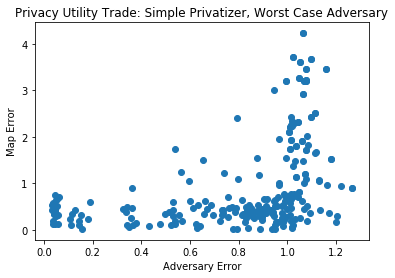

In [69]:
plt.scatter(true_data[:,2], true_data[:,1])
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

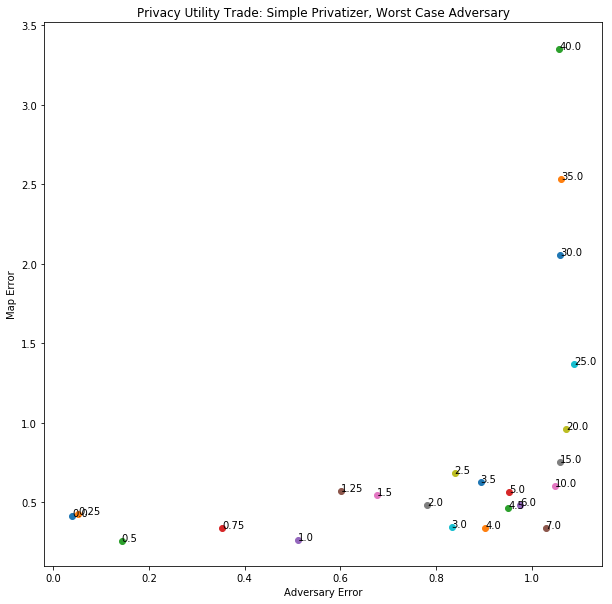

In [122]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(true_data[:,0]):
    indices = np.where(true_data[:,0]==i)
    plt.scatter(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.plot(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.text(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]), str(true_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

In [2]:
def train(trainstep, trainloss, max_iter, session):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=session)
        trainstep.run(session=session)
        delta2 = trainloss.eval(session=session)
        plotlist.append(trainloss.eval(session=session))
    return plotlist

In [196]:
def run_plot_automation():

    PENALTY = [0.01, 0.2]
    I = 10
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            strategy = "GAP"

            sess = tf.Session()
            keras.backend.set_session(sess)

            x, trueusers = sampleChania(Chania, 100)

            if strategy == "GAP":

                init = keras.initializers.Identity(gain=1.0)
                p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
                p5 = keras.layers.Dense(4, kernel_initializer=init)

                y = p5(p4(p3(p2(p1(x)))))
                p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

            i1 = keras.layers.Dense(4, activation=tf.nn.relu)
            i2 = keras.layers.Dense(4, activation=tf.nn.relu)
            i3 = keras.layers.Dense(4, activation=tf.nn.relu)
            i4 = keras.layers.Dense(1)

            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
            m1_train = tf.train.GradientDescentOptimizer(0.2)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

            o1 = keras.layers.Dense(4, activation=tf.nn.relu)
            o2 = keras.layers.Dense(4, activation=tf.nn.relu)
            o3 = keras.layers.Dense(4, activation=tf.nn.relu)
            o4 = keras.layers.Dense(1)

            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
            m2_train = tf.train.GradientDescentOptimizer(0.2)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a1 = keras.layers.Dense(7, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.08)
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            m2_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            privatizer_loss = tf.placeholder(tf.float32)
            penalty = tf.placeholder(tf.float32)
            threshold = tf.placeholder(tf.float32)
            testpoints = tf.placeholder(tf.float32)
            grid = tf.placeholder(tf.float32)

            sess.run(tf.global_variables_initializer())

            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
            m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
            m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            a_train = a_train.minimize(adversary_loss, var_list = a_vars)

            if strategy == "GAP":
                combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
                p_train = tf.train.GradientDescentOptimizer(0.1)
                
            testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)

            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)

            zero = tf.constant(0, dtype=tf.float32)
            privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:])))))), threshold))),
                                          tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))
                                          
            if strategy == "GAP":
                p_train = p_train.minimize(privatizer_loss, var_list = p_vars)


            delta1 = 1
            delta2 = 0
            count_iter = 0
            max_iter = 10

            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:

                delta1 = privatizer_loss.eval(session=sess)
                m2plot = train(m2_train, m2_loss, 100, sess)
                m1plot = train(m1_train, m1_loss, 100, sess)
                aplot = train(a_train, adversary_loss, 100, sess)
                pplot = train(p_train, privatizer_loss, 1, sess)
                delta2 = privatizer_loss.eval(session=sess)

                count_iter += 1
                
            index = int(I*P+i)
            
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:]))))))
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))
            
            all_data[index] = [PENALTY[P], map_error.eval(session=sess), adversary_loss.eval(session=sess)]

            tf.keras.backend.clear_session()
            
    return all_data
            
all_data = run_plot_automation()

1.8565857 1.3287
0.059425104 1.059407
0.050087012 1.0714971
7.9476995e-05 1.0422798
0.059896685 0.8547379
0.5856869 1.0414546
0.3611578 1.0205225
0.019177621 1.0300193
0.6911695 1.0459603
0.01751372 1.03727
0.074293755 1.3150097
0.12927313 0.8289429
0.12993447 0.6424403
0.7100337 0.47071508
0.034980334 1.1841683
0.0039588353 1.0366406
0.26873952 0.15472975
0.15677866 1.1076645
0.055782236 1.0420393
0.304119 0.48245555


Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

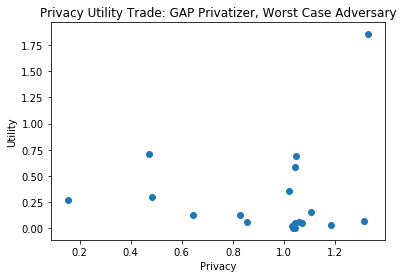

In [197]:
plt.scatter(all_data[:,2], all_data[:,1])
plt.xlabel("Privacy")
plt.ylabel("Utility")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

In [158]:
all_data = all_data[np.where(np.isnan(all_data[:,1])==False)]
all_data = all_data[np.where(all_data[:,2]>0.7)]

In [119]:
GAP_data = all_data

In [198]:
GAP_data = np.append(GAP_data, all_data, axis=0)

In [54]:
GAP_data = GAP_data[np.where(GAP_data[:,2] < 10)]

In [163]:
higherlearningrate = GAP_data

In [164]:
np.savetxt("higherlearningrate.txt", higherlearningrate)

In [3]:
GAP_data = np.loadtxt("higherlearningrate.txt")

In [106]:
GAP_data = GAP_data[np.where(GAP_data[:,2] < 10)]

Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

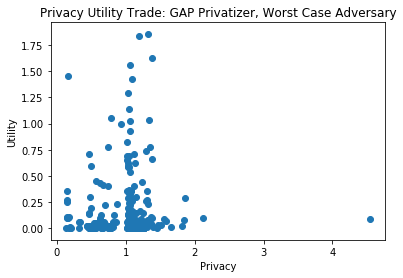

In [199]:
plt.scatter(GAP_data[:,2], GAP_data[:,1])
plt.xlabel("Privacy")
plt.ylabel("Utility")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

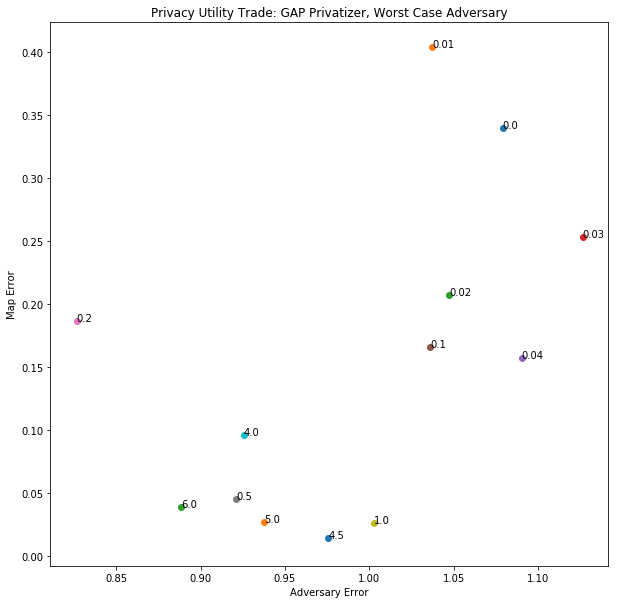

In [200]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(GAP_data[:,0]):
    indices = np.where(GAP_data[:,0]==i)
    plt.scatter(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]))
    plt.text(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]), str(GAP_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

## SIMPLE

In [46]:
NOISE = [0.25, 0.5, 0.75, 5]
all_data = np.empty((10*len(NOISE),3))
average_data = np.empty((6,3))

for N in range(len(NOISE)):

    for i in range(10):

        strategy = "simple"

        sess = tf.Session()
        keras.backend.set_session(sess)

        x, trueusers = sampleChania(Chania, 100)

        if strategy == "simple":
            yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(100,4))
            y = tf.constant(yarray, tf.float32)

        i1 = keras.layers.Dense(4, activation=tf.nn.relu)
        i2 = keras.layers.Dense(4, activation=tf.nn.relu)
        i3 = keras.layers.Dense(4, activation=tf.nn.relu)
        i4 = keras.layers.Dense(1)

        m1 = i4(i3(i2(i1(x[:,2:]))))
        m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
        m1_train = tf.train.GradientDescentOptimizer(0.2)
        m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

        o1 = keras.layers.Dense(4, activation=tf.nn.relu)
        o2 = keras.layers.Dense(4, activation=tf.nn.relu)
        o3 = keras.layers.Dense(4, activation=tf.nn.relu)
        o4 = keras.layers.Dense(1)

        m2 = o4(o3(o2(o1(y[:,2:]))))
        m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
        m2_train = tf.train.GradientDescentOptimizer(0.2)
        m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

        a1 = keras.layers.Dense(7, activation=tf.nn.relu)
        a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

        users = a2(a1(y))
        a_train = tf.train.GradientDescentOptimizer(0.08)
        a_vars = [a1.variables, a2.variables]

        m1_loss = tf.placeholder(tf.float32)
        m2_loss = tf.placeholder(tf.float32)
        map_error = tf.placeholder(tf.float32)
        adversary_loss = tf.placeholder(tf.float32)
        privatizer_loss = tf.placeholder(tf.float32)
        penalty = tf.placeholder(tf.float32)
        threshold = tf.placeholder(tf.float32)
        testpoints = tf.placeholder(tf.float32)
        grid = tf.placeholder(tf.float32)

        sess.run(tf.global_variables_initializer())

        m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
        m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

        m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
        m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

        adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
        a_train = a_train.minimize(adversary_loss, var_list = a_vars)

        if strategy == "simple":
            combined = a2(a1(y))

        testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
        grid = tf.constant(testpoints, dtype=tf.float32)
        map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:]))))))
        def train(trainstep, trainloss, max_iter, session):
            plotlist = []
            delta1 = 100
            delta2 = 0
            count_iter = 0
            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
                count_iter += 1
                delta1 = trainloss.eval(session=session)
                trainstep.run(session=session)
                delta2 = trainloss.eval(session=session)
                plotlist.append(trainloss.eval(session=session))
            return plotlist

        if strategy == "simple":

            m2plot = train(m2_train, m2_loss, 1000, sess)    
            m1plot = train(m1_train, m1_loss, 1000, sess)
            aplot = train(a_train, adversary_loss, 1000, sess)    
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))

        index = int(10*N+i)
        all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
        
        tf.keras.backend.clear_session()

    average_data[N] = [NOISE[N], np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,1]), np.mean(all_data[np.where(all_data[:,0]==NOISE[N])][:,2])]


0.32856393 0.059640747
0.28250274 0.05338914
0.106790155 0.048492864
0.20045015 0.04752367
0.043549947 0.04969822
0.05090663 0.05149092
0.19356066 0.041797638
0.2081393 0.047847524
0.21393406 0.04695077
0.30867577 0.044972096
0.060062677 0.15312259
0.0012927115 0.12140464
0.0937362 0.16455515
0.3432584 0.16922377
0.10136067 0.14511603
0.16147333 0.15519027
0.58900946 0.11026596
0.11073267 0.16174643
0.19652463 0.14915493
0.14740719 0.0993757
0.37064007 0.32935712
0.74001825 0.38153183
0.2234661 0.33213803
0.5190123 0.34402654
0.41666627 0.3661362
0.016523173 0.37668824
0.19698815 0.31878752
0.16000217 0.3473753
0.2710276 0.39058477
0.333981 0.36036026
0.09921981 1.049115
2.4150891 0.92845845
18.755987 1.0035962
0.048794407 0.91045576
8.382084 1.0372537
15.826377 0.9610663
23.368685 0.8901536
2.8720849 0.85186857
0.28785968 1.0322926
0.17709582 1.0305588


In [66]:
all_data = all_data[np.where(np.isnan(all_data[:,1])==False)]

In [166]:
true_data = np.loadtxt("simplelossprime.txt")

In [74]:
true_data = np.append(true_data, all_data, axis=0)
# true_data = all_data

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

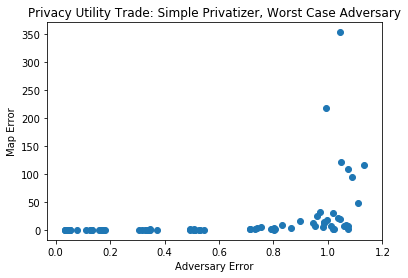

In [167]:
plt.scatter(true_data[:,2], true_data[:,1])
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

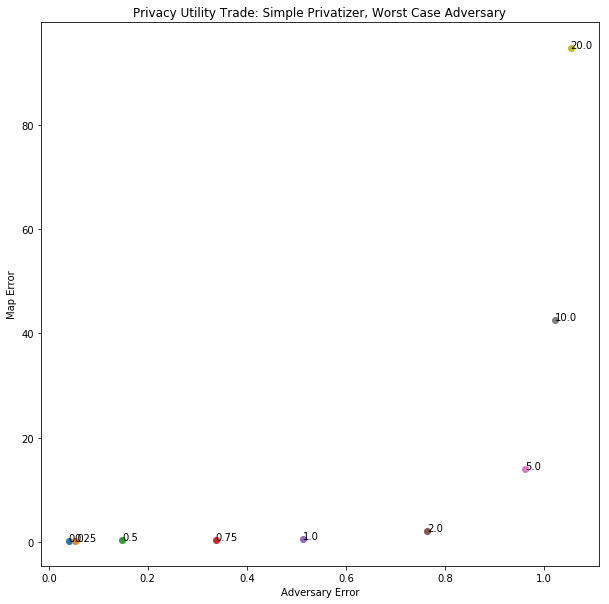

In [168]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(true_data[:,0]):
    indices = np.where(true_data[:,0]==i)
    plt.scatter(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.plot(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]))
    plt.text(np.mean(true_data[indices][:,2]), np.mean(true_data[indices][:,1]), str(true_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")

In [106]:
np.savetxt("simplelossprime.txt", true_data)

In [189]:
strategy = "simple"

print("For Worst Case Privacy, Best Case Utility")

for i in range(1):

    sess = tf.Session()
    keras.backend.set_session(sess)
    init = keras.initializers.Identity(gain=1.0)

    x, trueusers = sampleChania(Chania, 100)

    if strategy == "simple":
        y = x

    i1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    i2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    i3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    i4 = keras.layers.Dense(1)

    m1 = i4(i3(i2(i1(x[:,2:]))))
    m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
    m1_train = tf.train.GradientDescentOptimizer(0.2)
    m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

    o1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    o2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    o3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    o4 = keras.layers.Dense(1)

    m2 = o4(o3(o2(o1(y[:,2:]))))
    m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
    m2_train = tf.train.GradientDescentOptimizer(0.2)
    m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

    a1 = keras.layers.Dense(7, kernel_initializer=init, activation=tf.nn.relu)
    a2 = keras.layers.Dense(5, kernel_initializer=init, activation=tf.nn.softmax)

    users = a2(a1(y))
    a_train = tf.train.GradientDescentOptimizer(0.08)
    a_vars = [a1.variables, a2.variables]

    m1_loss = tf.placeholder(tf.float32)
    m2_loss = tf.placeholder(tf.float32)
    map_error = tf.placeholder(tf.float32)
    adversary_loss = tf.placeholder(tf.float32)
    privatizer_loss = tf.placeholder(tf.float32)
    penalty = tf.placeholder(tf.float32)
    threshold = tf.placeholder(tf.float32)
    testpoints = tf.placeholder(tf.float32)
    grid = tf.placeholder(tf.float32)

    sess.run(tf.global_variables_initializer())

    m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
    m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

    m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
    m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

    print(users.eval(session=sess)[0:10])
    print(tf.one_hot(trueusers.eval(session=sess),5).eval(session=sess)[0:10])
    
    print(tf.losses.softmax_cross_entropy(tf.one_hot(trueusers.eval(session=sess),5), users).eval(session=sess))
    
    adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
    
    print(adversary_loss.eval(session=sess))
    
    a_train = a_train.minimize(adversary_loss, var_list = a_vars)

    if strategy == "simple":
        combined = a2(a1(y))

    testpoints = np.mgrid[-1.5:0.75:15j, -1.5:0.75:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    def train(trainstep, trainloss, max_iter, session):
        plotlist = []
        delta1 = 100
        delta2 = 0
        count_iter = 0
        while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
            count_iter += 1
            delta1 = trainloss.eval(session=session)
            trainstep.run(session=session)
            delta2 = trainloss.eval(session=session)
            plotlist.append(trainloss.eval(session=session))
        return plotlist

    if strategy == "simple":

        m2plot = train(m2_train, m2_loss, 1000, sess) 
        m1plot = train(m1_train, m1_loss, 1000, sess)
        aplot = train(a_train, adversary_loss, 1000, sess)  
        map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                            o4(o3(o2(o1(y[:,2:]))))))    
        print(map_error.eval(session=sess), adversary_loss.eval(session=sess))

For Worst Case Privacy, Best Case Utility
[[0.5013218  0.12466952 0.12466952 0.12466952 0.12466952]
 [0.12786461 0.15158714 0.22145447 0.3794637  0.11963008]
 [0.1289534  0.18109724 0.21205015 0.36334935 0.11454985]
 [0.2680191  0.1501439  0.2815491  0.1501439  0.1501439 ]
 [0.28271297 0.10078062 0.19084823 0.32487753 0.10078062]
 [0.10292115 0.25328684 0.19335938 0.3475115  0.10292115]
 [0.16972326 0.16972326 0.32110703 0.16972326 0.16972326]
 [0.12861614 0.15145652 0.22126365 0.37913674 0.119527  ]
 [0.26873392 0.12502088 0.18305992 0.32452086 0.09866442]
 [0.16995028 0.16995028 0.32019895 0.16995028 0.16995028]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
1.5651883
1.4861212
0.45973834 0.03663083


### LOWER BOUNDS ON ERROR
Map error: 0.1087612544  
Adversary error: 0.0396815408

### That new new

In [60]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

def sampleChania(Chania, n_points):
    np.random.seed(2)
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

Chania = np.genfromtxt('processedChania.csv', delimiter=',')

Chania = Chania[np.where(Chania[:,2]<99)]

In [85]:
def train(trainstep, trainloss, max_iter, session, vis=False):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=session)
        trainstep.run(session=session)
        delta2 = trainloss.eval(session=session)
        plotlist.append(trainloss.eval(session=session))
        
        
    if vis:
        if abs(delta1-delta2) < 0.0001:
#             print("converged in", count_iter, "steps")
            pass

        else:
            plt.plot(plotlist)
            raise ValueError()
    
    return plotlist

An adversary who assigns labels randomly would do this well:
1.6261361

privatizer converged in 2 steps
0.0025787475 1.48036


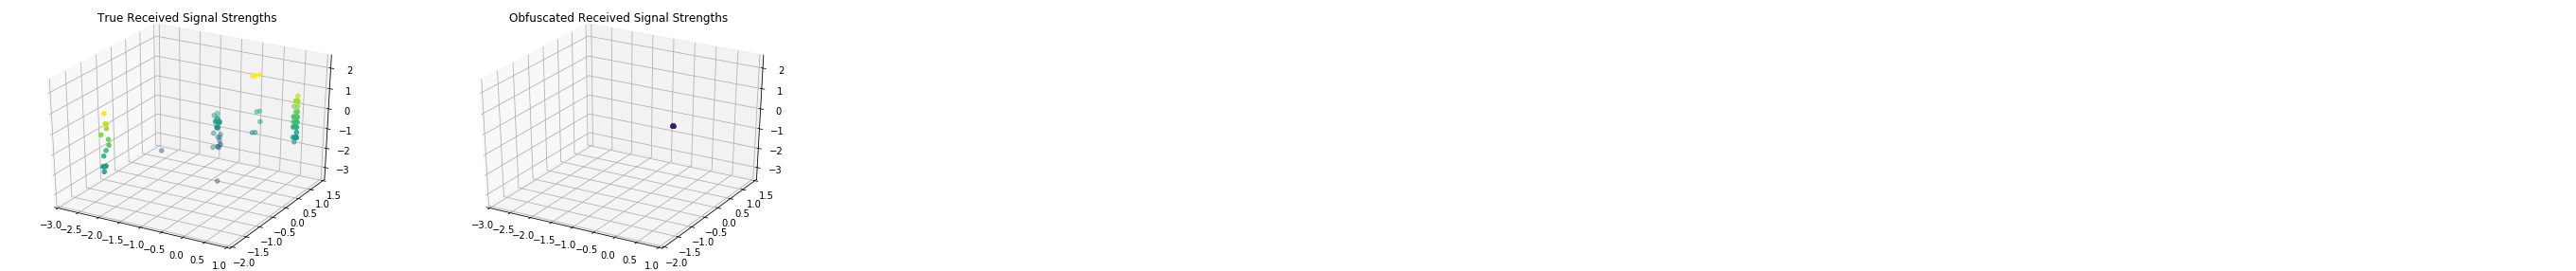

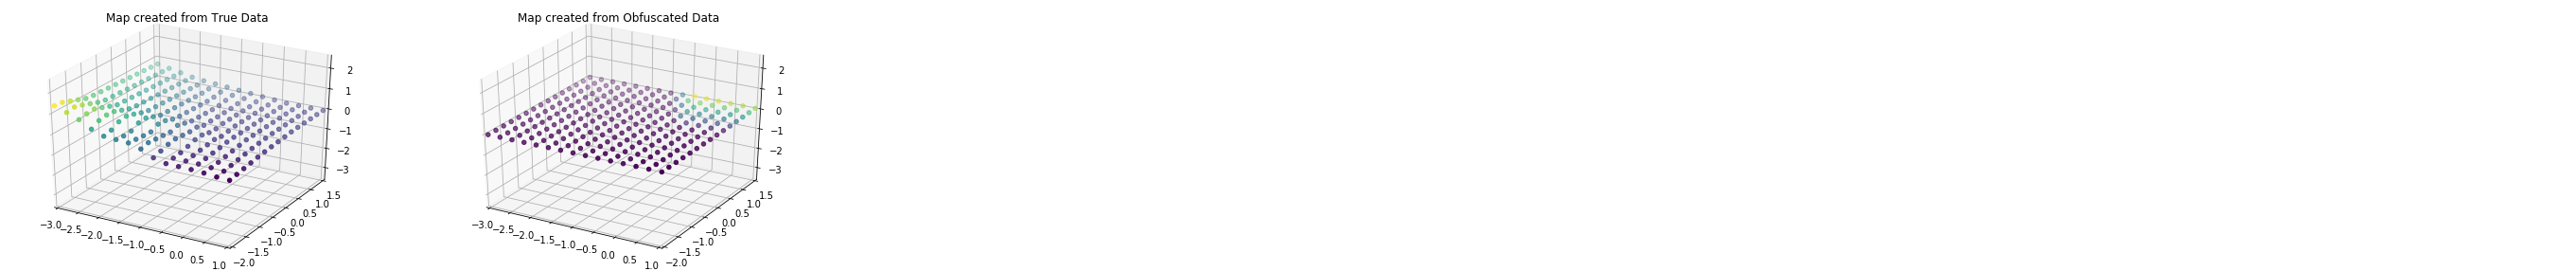

In [115]:
def run_plot_automation():

    PENALTY = [0.0]
    I = 1
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            strategy = "GAP"

            sess = tf.Session()
            keras.backend.set_session(sess)

            x, trueusers = sampleChania(Chania, 100)

            if strategy == "GAP":

                p_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=0)
                p1 = keras.layers.Dense(4, kernel_initializer=p_init, activation=tf.nn.relu)
                p2 = keras.layers.Dense(4, kernel_initializer=p_init, activation=tf.nn.relu)
                p3 = keras.layers.Dense(4, kernel_initializer=p_init, activation=tf.nn.relu)
                p4 = keras.layers.Dense(4, kernel_initializer=p_init, activation=tf.nn.relu)
                p5 = keras.layers.Dense(4, kernel_initializer=p_init)

                y = p5(p4(p3(p2(p1(x)))))
                p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init, activation=tf.nn.relu)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init, activation=tf.nn.relu)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init, activation=tf.nn.relu)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)

            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=2)
            o1 = keras.layers.Dense(4, kernel_initializer=map2_init, activation=tf.nn.relu)
            o2 = keras.layers.Dense(4, kernel_initializer=map2_init, activation=tf.nn.relu)
            o3 = keras.layers.Dense(4, kernel_initializer=map2_init, activation=tf.nn.relu)
            o4 = keras.layers.Dense(1, kernel_initializer=map2_init)
            
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)

            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.05)
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            m2_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            privatizer_loss = tf.placeholder(tf.float32)
            map_error = tf.placeholder(tf.float32)
            penalty = tf.placeholder(tf.float32)
            threshold = tf.placeholder(tf.float32)
            testpoints = np.mgrid[-2:1.5:15j, -3:1:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            
            sess.run(tf.global_variables_initializer())
            
            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
            m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
            m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)
            
            random_users = tf.constant(np.random.rand(100,5),dtype=tf.float32)
            print("An adversary who assigns labels randomly would do this well:")
            print(tf.losses.softmax_cross_entropy(tf.one_hot(trueusers.eval(session=sess),5), random_users).eval(session=sess))
            print("")
            
            adversary_loss = tf.losses.softmax_cross_entropy(tf.one_hot(trueusers.eval(session=sess),5), users)
            a_train = a_train.minimize(adversary_loss, var_list = a_vars)

            if strategy == "GAP":
                p_train = tf.train.GradientDescentOptimizer(0.1)
                
            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)
            
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(i4(i3(i2(i1(y[:,2:])))), 
                                                                                o4(o3(o2(o1(y[:,2:]))))))

            zero = tf.constant(0, dtype=tf.float32)
            privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(map_error, threshold))),
                                          tf.losses.softmax_cross_entropy(tf.one_hot(trueusers.eval(session=sess),5), users))
                                          
            if strategy == "GAP":
                p_train = p_train.minimize(privatizer_loss, var_list = p_vars)


            delta1 = 1
            delta2 = 0
            count_iter = 0
            max_iter = 1000
            
            m1plot = train(m1_train, m1_loss, 10000, sess, True)

            while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:

                delta1 = privatizer_loss.eval(session=sess)
                m2plot = train(m2_train, m2_loss, 3000, sess, True)
                aplot = train(a_train, adversary_loss, 2000, sess, True)
                pplot = train(p_train, privatizer_loss, 1, sess)
                delta2 = privatizer_loss.eval(session=sess)

                count_iter += 1
                
            if abs(delta1-delta2) < 0.0001:
                print("privatizer converged in", count_iter, "steps")
                
            else:
                print("privatizer did not converge")
                
            index = int(I*P+i)
            
            print(map_error.eval(session=sess), adversary_loss.eval(session=sess))
            
            all_data[index] = [PENALTY[P], map_error.eval(session=sess), adversary_loss.eval(session=sess)]

            if i != I:
                tf.keras.backend.clear_session()
            
    if True:
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)
        
        # fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)
        outputmap = o4(o3(o2(o1(grid)))).eval(session=sess)

        ax.scatter(testpoints[:,1], testpoints[:,0], inputmap[:,0], c=inputmap[:,0])
        ax.set_title("Map created from True Data")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(testpoints[:,1], testpoints[:,0], outputmap[:,0], c=outputmap[:,0])
        ax1.set_title("Map created from Obfuscated Data")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)
        
    tf.keras.backend.clear_session()
    
    return all_data, trueusers.eval(session=sess), np.argmax(users.eval(session=sess), axis=1)
            
all_data, trueusers, users = run_plot_automation()

In [98]:
trueusers = tf.constant(trueusers, dtype=tf.float32)

In [99]:
users = tf.constant(users, dtype=tf.float32)

In [110]:
tf.math.count_nonzero(trueusers-users)/tf.shape(trueusers)

TypeError: x and y must have the same dtype, got tf.int64 != tf.int32

In [50]:
all_data

array([[0.        , 4.01420975, 1.63610435],
       [0.01      , 2.68613291, 1.63338208],
       [0.02      , 2.07356572, 1.63420427],
       [0.03      , 1.67671406, 1.6341604 ],
       [0.04      , 0.46712545, 1.63483238],
       [0.05      , 0.37934127, 1.63482153]])

In [51]:
GAP_data = all_data

In [47]:
GAP_data = np.append(GAP_data, all_data, axis=0)

Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

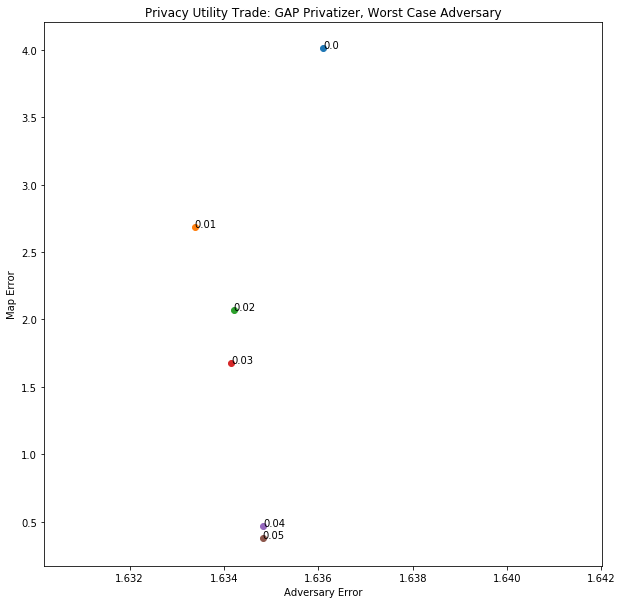

In [52]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(GAP_data[:,0]):
    indices = np.where(GAP_data[:,0]==i)
    plt.scatter(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]))
    plt.text(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]), str(GAP_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

In [39]:
tf.keras.backend.clear_session()

0.12252398 1.479899